Filtern

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

#from shapely.geometry import Point
# import geopandas as gpd
# from geopandas import GeoDataFrame

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

Als erster wir die CSV Datei importiert und als Dataframe abgelegt.

In [84]:
url = 'C:/Users/oache/Desktop/KI_ML/vehicles/vehicles.csv'
#url= 'C:/Users/nicof/OneDrive/Dokumente/FH-München/KI\Modularbeit/archive/vehicles.csv'
df = pd.read_csv(url)


Als nächstes lassen wir uns die ersten fünf Einträge anzeigen, um einen Überblick über die Daten zu erlangen. Es fällt auf, dass einige der Spalten für die Vorhersage des Preises nicht von nutzen sein werden.

In [85]:
df.head(5)


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


Um einen Überblick zu bekommen mit wievielen Daten wir uns beschäftigen lassen wir uns die Dimensionen des Dataframes anzeigen. Wir haben ein Datenfeld in der größe 426880 x 26

In [86]:
df.shape

(426880, 26)

Um eine Überblick über die Fahrzeughersteller und deren Inseratanteilen zu bekommen lassen wir uns dies anhande der Stückzahlen anzeigen.

<BarContainer object of 42 artists>

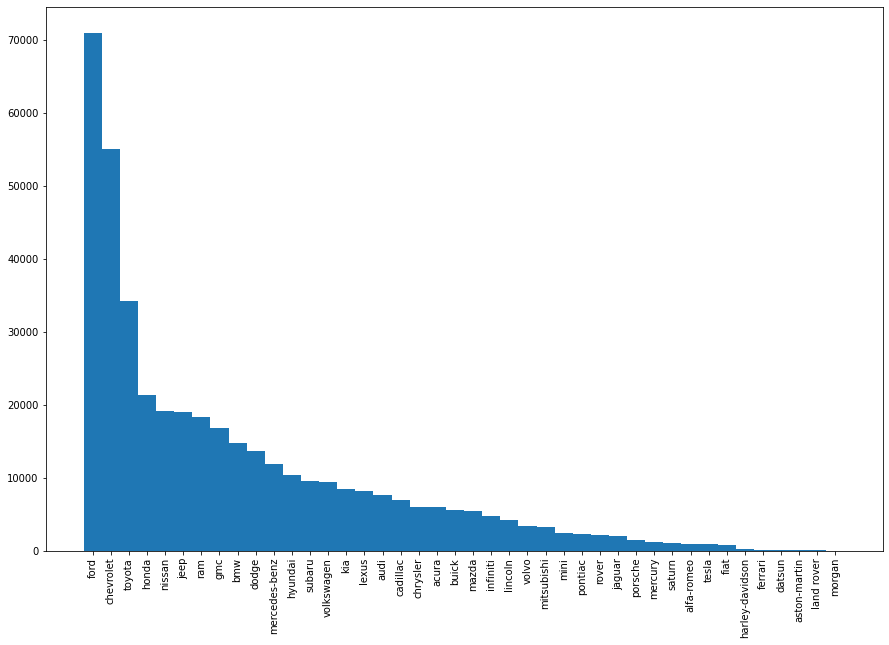

In [87]:
x = (df.groupby(['manufacturer'],as_index = False).count().sort_values('price', ascending = False))['manufacturer'].tolist()
y = (df.groupby(['manufacturer'],as_index = False).count().sort_values('price', ascending = False))['price'].tolist()
fig = plt.figure(figsize=(15,10))
plt.xticks(rotation = 90)
plt.bar(x, y, width=1)

Wir lassen uns die unterschiedlichen Angaben zu den jeweiligen Kategorien anzeigen.

In [88]:
#Information about the categorical variables

print(df["paint_color"].unique())
print(df["condition"].unique())
print(df["type"].unique())
print(df["fuel"].unique())
print(df["cylinders"].unique())
print(df["title_status"].unique())
print(df["type"].unique())
print(df["drive"].unique())
print(df["transmission"].unique())

[nan 'white' 'blue' 'red' 'black' 'silver' 'grey' 'brown' 'yellow'
 'orange' 'green' 'custom' 'purple']
[nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']
[nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
[nan 'gas' 'other' 'diesel' 'hybrid' 'electric']
[nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']
[nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']
[nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
[nan 'rwd' '4wd' 'fwd']
[nan 'other' 'automatic' 'manual']


Um einen Überblick zu erhalten, wie oft in der jeweiligen Kategorie kein Eintrag vorhanden ist lassen wir uns dies Anzeigen.

In [89]:
df.isnull().sum().sort_values(ascending = False)

county          426880
size            306361
cylinders       177678
condition       174104
VIN             161042
drive           130567
paint_color     130203
type             92858
manufacturer     17646
title_status      8242
lat               6549
long              6549
model             5277
odometer          4400
fuel              3013
transmission      2556
year              1205
description         70
image_url           68
posting_date        68
url                  0
price                0
state                0
region_url           0
region               0
id                   0
dtype: int64

Um die Vorhersage des Preises präziser zu ermöglichen, entfernen wir die Spalten aus dem Dataframe die wir für unnötige erachten:
- county: extrem hohe Anzahl ein Nan einträgen.
- size: extrem hohe Anzahl ein Nan einträgen.
- id, url, region_url, lat, long, vin, image_url, description, geometry: Diese Angaben sind teilweise sehr individuell (z.B. description), oder für eine Preisvorhersage nicht relevant.
- size: Die "größe" des Fahrzeugs ist Modellabhängig und kann somit ebenfalls entfernt werden.
- region: Diese Angabe ist sehr präzise wir nutzen die Angaben in der Kategorie 'state' zur örtlichen Einschränkung.

In [90]:


df.drop([ 'id', 'url', 'region_url', 'lat', 'long', 'VIN', 'image_url',
         'description', 'county','size','region'], axis = 1, inplace = True)
df.head(5)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
0,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN
1,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN
2,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN
4,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN


In der Kategorie "title_status" sind die Angaben [nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only'] vorhanden.(siehe oben) Für eine Preisvorhersage von Fahrzeugen, können die Inserate mit dem Titel 'rebuilt' 'lien' 'salvage' 'missing' 'parts only' jedoch nicht verwendet werden, weshalb title_status als gesamte Spalte gedropt werden kann. 

In [91]:

df.drop('title_status',axis=1, inplace= True)


Aussortieren von Inseraten mit unrealistischen Preisen

In [92]:
df = df[((df['price'] < 500000) & (df['price'] > 100))]

Jetzt lassen wir uns die Fahrzeuginserate anhand der Baujahre und des zugehörigen Preises anzeigen.

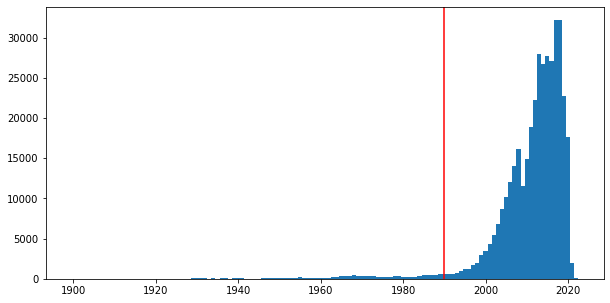

In [93]:
starting_year = 1990
x = (df.groupby(['year'],as_index = False).count())['year'].tolist()
y = (df.groupby(['year'],as_index = False).count())['price'].tolist()
fig = plt.figure(figsize=(10,5))
plt.bar(x, y, width=1)
plt.axvline(starting_year, color = 'red')

Die Anzahl an Fahrzeugen die vor 1990 gebaut wurden ist sehr gering und die Preise niedrig, für diese Fahrzeuge ist keine genau Preis Ermittlung möglich.

In [94]:

df = df[df['year'] > starting_year]


Fahrzeuge mit sehr hohen Tachostand (höchsten 1%) können ebenfalls ignoriert werden.

In [95]:
top1 = np.nanpercentile(df['odometer'], 99)
df = df[df['odometer'] < top1]

Fahrzeuge die keine Angeben in den Spalten fuel, transmission, manufacturer und model können ebenfalls vernächlässigt werden, da diese Angaben hohe Priorität haben.

In [96]:
#delete unknown fuel, transmission and title_status instances

df.dropna(subset = ['fuel', 'transmission'], axis = 0, inplace = True)
df = df[~df['manufacturer'].isnull()]
df = df[~df['model'].isnull()]
df.shape

(352514, 14)

Um im späteren Verlauf eine Prediction zu ermöglichen ersetzen wir in den restlichen Spalten die Nan Angaben durch unknowen bzw. not specified

In [97]:
#replace missing condition values with 'not specified'

df['condition'].fillna('not specified', inplace = True)
df['paint_color'].fillna('unknown', inplace = True)


Da in einigen inseraten Modell verschieden beschrieben werden z.B. F150, F150 good condition, F-150 beschränken wir uns auf das erste Wort in der Beschreibung und entfernen alle Modelle die anschließend weniger als 150 mal auftreten. Desweitern fügen wir den manufacturer in der Spalte model hinzu, um zu vermeiden, dass Fahrzeuge die den gleichen Modellnamen jedoch von unterschiedlichen Herstellern sind, zusammengfügt werden. Dies machen wir in einem speraten Dataframe um uns die Unterschiede anzeigen lassen zu können

In [98]:


model_list = df['model'].tolist()
model_list = map(str, model_list)
model_list = [x.lower().strip() for x in model_list]
my_list = [car_model.split()[0] for car_model in model_list]
my_list = [x.replace(' ', '').replace('-', '').replace('/', '') for x in my_list]

df['car_model'] = my_list
df['car_model'] = df['manufacturer'] + " " + df['car_model']

new_car_models = (df.groupby(['car_model'], as_index= False).count())[['manufacturer', 'car_model', 'price']]
new_car_models = new_car_models.rename(columns={'price': 'count'})
only_common_models = new_car_models[new_car_models['count'] > 150]
#evtl löschen
print('Alle models ', len(new_car_models['count']))
print('models mit mehr als 150 Einträgen: ', len(only_common_models['count']))
print('Prozentualeranteil an gelöschten models:', round((1-len(only_common_models['count'])/len(new_car_models['count'])) * 100, 2))
print()
print('Gesamtanzahl an Inseraten: ', len(df['price']))
print('Verbleibende Inserate: ', sum(only_common_models['count']))
print('Prozentualeranteil an gelöschten Inseraten ', round((1-sum(only_common_models['count'])/len(df['price'])) * 100, 2))

Alle models  2542
models mit mehr als 150 Einträgen:  312
Prozentualeranteil an gelöschten models: 87.73

Gesamtanzahl an Inseraten:  352514
Verbleibende Inserate:  324925
Prozentualeranteil an gelöschten Inseraten  7.83


Um einen graphischen Überblick zu erhalten wieviele Fahrzeugemodell und Inserate gelöscht werden, wenn wir die mindest Anzahl auf 150 setzen lassen wir uns dies Anzeigen.

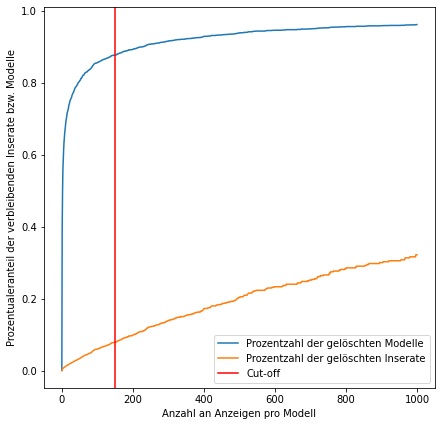

In [99]:
removed_models_list = []
removed_instances_list = []

for i in range(0,1000):
    only_common_models_v2 = new_car_models[new_car_models['count']>i]
    models_removed = 1-len(only_common_models_v2['count'])/len(new_car_models['count'])
    instances_removed = 1-sum(only_common_models_v2['count'])/len(df['price'])
    
    removed_models_list.append(models_removed)
    removed_instances_list.append(instances_removed)

fig = plt.figure(figsize=(7,7))
plt.plot(removed_models_list, label = 'Prozentzahl der gelöschten Modelle')
plt.plot(removed_instances_list, label = 'Prozentzahl der gelöschten Inserate')
plt.axvline(150 , color = 'red', label = 'Cut-off')
plt.ylabel('Prozentualeranteil der verbleibenden Inserate bzw. Modelle')
plt.xlabel('Anzahl an Anzeigen pro Modell')
plt.legend()

Wir sind mit unsere Grenze von min. 150 Fahrzeugen zufrieden, da noch genügend Daten für eine Preisvorhersage vorhanden sind und trotzdem stark genüg reduziert wurde um die Gefahr des overfittings zu veringern. 
Wir übernehmen unsere Änderungen im Hauptdataframe. Durch das zusammenfügen von manufacturer und model können wir die beiden Spalten ebenfalls dropen.

In [100]:
df = df[df['car_model'].isin(only_common_models['car_model'].tolist())]
df.drop('model', axis = 1, inplace = True)
df.drop('manufacturer',axis = 1, inplace= True)


In [101]:
df.head(5)

,price,year,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,posting_date,car_model
27,33590,2014.0,good,8 cylinders,gas,57923.0,other,NaN,pickup,white,al,2021-05-04T12:31:18-0500,gmc sierra
28,22590,2010.0,good,8 cylinders,gas,71229.0,other,NaN,pickup,blue,al,2021-05-04T12:31:08-0500,chevrolet silverado
29,39590,2020.0,good,8 cylinders,gas,19160.0,other,NaN,pickup,red,al,2021-05-04T12:31:25-0500,chevrolet silverado
30,30990,2017.0,good,8 cylinders,gas,41124.0,other,NaN,pickup,red,al,2021-05-04T10:41:31-0500,toyota tundra
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,al,2021-05-03T14:02:03-0500,ford f150
32,27990,2012.0,good,8 cylinders,gas,68696.0,other,4wd,pickup,black,al,2021-05-03T13:41:25-0500,gmc sierra
33,34590,2016.0,good,6 cylinders,gas,29499.0,other,4wd,pickup,silver,al,2021-05-03T12:41:33-0500,chevrolet silverado
34,35000,2019.0,excellent,6 cylinders,gas,43000.0,automatic,4wd,truck,grey,al,2021-05-03T12:12:59-0500,toyota tacoma
35,29990,2016.0,good,6 cylinders,gas,17302.0,other,4wd,pickup,red,al,2021-05-03T11:31:14-0500,chevrolet colorado
36,38590,2011.0,good,8 cylinders,gas,30237.0,other,rwd,other,red,al,2021-05-03T07:50:35-0500,chevrolet corvette


Wir lassen uns das aktuelle Datafield anzeigen um einen Überblick zubekommen.

In [102]:
df.iloc[:,12]

27                 gmc sierra
28        chevrolet silverado
29        chevrolet silverado
30              toyota tundra
31                  ford f150
                 ...         
426875          nissan maxima
426876              volvo s60
426877           cadillac xt4
426878               lexus es
426879                  bmw 4
Name: car_model, Length: 324925, dtype: object

In [103]:
 i=0
 for x in df.posting_date:
     df.iloc[i,12]=x[:7:]
     i=i+1

 df
 print(df["posting_date"].unique())



['2021-05-04T12:31:18-0500' '2021-05-04T12:31:08-0500'
 '2021-05-04T12:31:25-0500' ... '2021-04-04T03:21:17-0600'
 '2021-04-04T03:21:11-0600' '2021-04-04T03:21:07-0600']


Da alle Inserate innerhalb der letzten zwei Monaten angeboten wurden können wir die Splate 'posting_date' ebenfalls entfernen.

In [104]:
df=df.drop('posting_date',axis=1)

In der Splate cylinders ersetzen wir die Werte Nan durch den Median und löschen die Einträge mit der Angabe 'others'.

In [105]:
df = df[df['cylinders'] != 'other']
dftest = df.copy()
test = df[df['cylinders'].notnull()].copy()
test['cylinders'] = [int(cyl.split()[0]) for cyl in test['cylinders']]
med = test.groupby('car_model')['cylinders'].median()
merged = pd.merge(dftest, med, on = 'car_model', how = 'left')
merged['cylinders_y'].fillna(med.median(), inplace = True)
merged['cylinders_x'].fillna(merged['cylinders_y'], inplace = True)

li = []
for cyl in merged['cylinders_x']:
    if type(cyl) == str:
        li.append(cyl)
    else:
        li.append(str(int(cyl)) + " cylinders")

df['cylinders'] = li


Wir fügen in der Spalte "drive" bei Einträgen ohne Anagbe den am häuigst auftretenden Werte ein.

In [106]:
dftest = df.copy()
test = df[df['drive'].notnull()].copy()
mode = test.groupby('car_model')['drive'].agg(pd.Series.mode)
merged = pd.merge(dftest, mode, on = 'car_model', how = 'left')
merged['drive_x'].fillna(merged['drive_y'], inplace = True)

df['drive'] = merged['drive_x'].tolist()
#df['drive'].unique()

Selbiges führen wir für die Spalte "type" druch.

In [107]:
dftest = df.copy()
test = df[df['type'].notnull()].copy()
mode = test.groupby('car_model')['type'].agg(pd.Series.mode)
merged = pd.merge(dftest, mode, on = 'car_model', how = 'left')
merged['type_x'].fillna(merged['type_y'], inplace = True)

df['type'] = merged['type_x'].tolist()


Um zu überprüfen, ob keine weiteren Nan einträge in den Spalten vorhanden sind zählen wir die Einträge mit Nan in allen Kategorien

In [108]:
df.isnull().sum()

price           0
year            0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
type            0
paint_color     0
state           0
car_model       0
dtype: int64

Einträge die einen untypisch hohen Preis (dreifcher Durchschnittspreis) haben, entfernen wir ebenfalls aus dem Datensatz.

In [109]:
df = df[df['price'] < (3 * df.groupby('car_model')['price'].transform('mean'))]

Um eine Vorstellung zu bekommen wieviele Einträge und Spalten wir durch unsere Eingrenzungsmaßnahemn entferen konnten lassen wir uns erneut die Dimensionen des Dataframes anzeigen. Wir konnten von einem die Einträge im Dataframe von 426880 x 26 auf 304885 x 13 reduzieren.
Dies entspricht einer Kürzung von 121995 Zeilen und 13 Spalten.

In [110]:
df.shape

(318817, 12)

Wir erstellen eine Kopie des Dataframes um es erneut herstellen zukönnen. Und erstellen die csv Datei clean.

In [111]:
clean = df.copy()

In [112]:
df.to_csv('clean.csv', index = False)

Wir trennen für unsere späteren Modelle unsere Daten nun in Testdaten und Trainingsdaten, wobei 80% der Daten für das Training verwenden, da wir diesen Wert häufig online gefunden werden. Damit das auftrennen der Daten nicht immer neu programmiert werden müssen, haben wir dies hier in eine Schleife gemacht. Innerhalb dieser haben wir die Daten dann noch zur Fehlervermeidung und um die Performance (für Modelle wie Linear Regression, K-nearest neighbors or support vector machines)zu verbessern mit StandardScalar standartisiert. 
Am Ende lassen wir uns dann noch die Abweichungen beziehungsweise die Genauigkeit der Vorhersagen sowohl der Trainingsdaten, als auch der Testdaten Anzeigen.
"Mae" ist dabei der absolute Fehler, "mse" der quadratische Fehler und "mape" der absolute Fehler in Prozent. r^2 sagt uns dabei zusätzlich, wie gut unsere Vorhersage die wirklichen Daten wiederspiegelt.

In [113]:
def updateModel(datafr, test_percentage = 0.2, seed = 7):
    
   
    X = datafr.drop('price', axis = 1)
    y = datafr['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_percentage, random_state = seed)
    X_train = pd.get_dummies(X_train, drop_first = True)
    X_test = pd.get_dummies(X_test, drop_first = True)
    
   
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
  
    reg.fit(X_train, y_train)
    y_pred_test = reg.predict(X_test)
    y_pred_train = reg.predict(X_train)
    
   
    test_metrics = {'r2': round(r2_score(y_test, y_pred_test) * 100, 2),
           'mae': round(mean_absolute_error(y_test, y_pred_test), 2),
           'mse': round(mean_squared_error(y_test, y_pred_test), 2),
           'mape': round(mean_absolute_percentage_error(y_test, y_pred_test) * 100, 2)
           }
    train_metrics = {'r2': round(r2_score(y_train, y_pred_train) * 100, 2),
           'mae': round(mean_absolute_error(y_train, y_pred_train), 2),
           'mse': round(mean_squared_error(y_train, y_pred_train), 2),
           'mape': round(mean_absolute_percentage_error(y_train, y_pred_train) * 100, 2)
           }
    
    return {'test_metrics': test_metrics,
            'train_metrics': train_metrics}

Damit unsere Daten innerhalb eines Modells nicht zu einseitig trainiert werden, zum Beispiel nur auf günstigen oder nur auf teuren Autos, splitten wir die gesamten Daten in fünf "Gruppen" auf, aus denen wir unsere Testdaten und unsere  Trainingsdaten in unserer Funktion (ein Feld oben drüber) dann trainieren.

In [114]:
def get_kCVscores(datafr, k = 5, scoring = 'neg_mean_absolute_error'):
    X = datafr.drop('price', axis = 1)
    X = pd.get_dummies(X, drop_first = True)
    y = datafr['price']
    return (cross_val_score(reg, X, y, cv = k, scoring = scoring) * (-1))

Mit K-Means Clustern wir unsere Daten. K-Means hat den Vorteil,dass es die Daten relativ schnell clustert, solange diese nicht zu komplex sind. Dies ist hier der Fall. 

In [115]:
def k_means_clustering(datafr, k):
    df_to_return = datafr.copy()
    df_with_dummies = pd.get_dummies(datafr, drop_first = True)
    km = KMeans(n_clusters = k)
    df_to_return['cluster'] = km.fit_predict(df_with_dummies)
    
    return df_to_return

Die lineare Regression ist ein einfaches Modell, weswegen es auch nur eine sehr kurze Rechenzeit benötigt. Dafür hat es im gegenzug teilweise auch relativ große Abweichungen bei seiner Vorhersage (mae= 4386.93).

In [116]:
reg = LinearRegression()

In [117]:
df.head(5)


,price,year,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,car_model
27,33590,2014.0,good,8 cylinders,gas,57923.0,other,4wd,pickup,white,al,2021-05
28,22590,2010.0,good,8 cylinders,gas,71229.0,other,4wd,pickup,blue,al,2021-05
29,39590,2020.0,good,8 cylinders,gas,19160.0,other,4wd,pickup,red,al,2021-05
30,30990,2017.0,good,8 cylinders,gas,41124.0,other,4wd,pickup,red,al,2021-05
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,al,2021-05


In [118]:
init_metrics = updateModel(df)
def print_metrics(metrics):
    print('test performance:', metrics['test_metrics'])
    print('initial test performance:', init_metrics['test_metrics'])
    print()
    print('train performance:', metrics['train_metrics'])
    print('initial train performance:', init_metrics['train_metrics'])
    print()
    print('change in test MAE:', round((init_metrics['test_metrics']['mae'] - metrics['test_metrics']['mae']) / 
      (init_metrics['test_metrics']['mae']) * 100, 2), '%')
print_metrics(init_metrics)

test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 0.0 %


Nun werden die Staaten durch ihre jeweilige Region, wie Westen,Süden,Südwesten und soweiter ersetzt und in einem Dataframe gespeichert. 

In [119]:
regions_dict = {"state": ["al","ak","az","ar","ca","co","ct","de","dc","fl","ga","hi","id","il","in","ia","ks","ky","la","me","md","ma","mi","mn","ms","mo","mt","ne","nv","nh","nj","nm","ny","nc","nd","oh","ok","or","pa","ri","sc","sd","tn","tx","ut","vt","va","wa","wv","wi","wy"], 
         "region": ["south","west","west","south","west","west","north-east","south","south","south","south","west","west","mid-west","mid-west","mid-west","mid-west","south","south","north-east","south","north-east","mid-west","mid-west","south","mid-west","west","mid-west","west","north-east","north-east","west","north-east","south","mid-west","mid-west","south","west","north-east","north-east","south","mid-west","south","south","west","north-east","south","west","south","mid-west","west"]}
dfState = pd.merge(df, pd.DataFrame(regions_dict), on = 'state', how = 'left').drop('state', axis = 1)
dfState

,price,year,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,car_model,region
0,33590,2014.0,good,8 cylinders,gas,57923.0,other,4wd,pickup,white,2021-05,south
1,22590,2010.0,good,8 cylinders,gas,71229.0,other,4wd,pickup,blue,2021-05,south
2,39590,2020.0,good,8 cylinders,gas,19160.0,other,4wd,pickup,red,2021-05,south
3,30990,2017.0,good,8 cylinders,gas,41124.0,other,4wd,pickup,red,2021-05,south
4,15000,2013.0,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,2021-05,south
...,...,...,...,...,...,...,...,...,...,...,...,...
318812,23590,2019.0,good,6 cylinders,gas,32226.0,other,fwd,sedan,unknown,2021-04,west
318813,30590,2020.0,good,6 cylinders,gas,12029.0,other,fwd,sedan,red,2021-04,west
318814,34990,2020.0,good,6 cylinders,diesel,4174.0,other,4wd,hatchback,white,2021-04,west
318815,28990,2018.0,good,6 cylinders,gas,30112.0,other,fwd,sedan,silver,2021-04,west


Mit dem auf Regionen veränderten Dataframe testen wir nur erneut die Performance.

In [120]:
binned_states_metrics = updateModel(dfState)
print_metrics(binned_states_metrics)

test performance: {'r2': 64.43, 'mae': 5494.7, 'mse': 56801158.26, 'mape': 178.04}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 64.17, 'mae': 5510.18, 'mse': 57457401.54, 'mape': 183.07}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: -0.3 %


Da der Einfluss ob die Region oder der Staat im Dataframe ist, sehr klein (-0.17%) ist, kann dieser im weiteren vorgehen wahrscheinlich vernachlässigt werden. Um diese Hypothese zu überprüfen, erstellen wir den Dataframe ohne state.

In [121]:
dfDropState = df.drop('state', axis = 1)
dfDropState

,price,year,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,car_model
27,33590,2014.0,good,8 cylinders,gas,57923.0,other,4wd,pickup,white,2021-05
28,22590,2010.0,good,8 cylinders,gas,71229.0,other,4wd,pickup,blue,2021-05
29,39590,2020.0,good,8 cylinders,gas,19160.0,other,4wd,pickup,red,2021-05
30,30990,2017.0,good,8 cylinders,gas,41124.0,other,4wd,pickup,red,2021-05
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,2021-05
...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,good,6 cylinders,gas,32226.0,other,fwd,sedan,unknown,2021-04
426876,30590,2020.0,good,6 cylinders,gas,12029.0,other,fwd,sedan,red,2021-04
426877,34990,2020.0,good,6 cylinders,diesel,4174.0,other,4wd,hatchback,white,2021-04
426878,28990,2018.0,good,6 cylinders,gas,30112.0,other,fwd,sedan,silver,2021-04


Mit diesen Dataframe wird erneut das Modell getestet und der Einfluss ist mit -0,9% wirklich sehr gering.

In [122]:
drop_state_metrics = updateModel(dfDropState)
print_metrics(drop_state_metrics)

test performance: {'r2': 64.15, 'mae': 5528.95, 'mse': 57246099.97, 'mape': 177.13}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 63.91, 'mae': 5541.87, 'mse': 57876572.82, 'mape': 182.36}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: -0.92 %


Als nächstes wird der Einfluss vom Car_model ähnlich dem vom state getestet. Nur dieses mal wird direkt die Spalte car_model gedroppt und in einen Dataframe gespeichert.

In [123]:
dfNoCarModel = df.drop('car_model', axis = 1)
dfNoCarModel

,price,year,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state
27,33590,2014.0,good,8 cylinders,gas,57923.0,other,4wd,pickup,white,al
28,22590,2010.0,good,8 cylinders,gas,71229.0,other,4wd,pickup,blue,al
29,39590,2020.0,good,8 cylinders,gas,19160.0,other,4wd,pickup,red,al
30,30990,2017.0,good,8 cylinders,gas,41124.0,other,4wd,pickup,red,al
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,good,6 cylinders,gas,32226.0,other,fwd,sedan,unknown,wy
426876,30590,2020.0,good,6 cylinders,gas,12029.0,other,fwd,sedan,red,wy
426877,34990,2020.0,good,6 cylinders,diesel,4174.0,other,4wd,hatchback,white,wy
426878,28990,2018.0,good,6 cylinders,gas,30112.0,other,fwd,sedan,silver,wy


In [124]:
no_car_model_metrics = updateModel(dfNoCarModel)
print_metrics(no_car_model_metrics)

test performance: {'r2': 64.65, 'mae': 5479.81, 'mse': 56442822.44, 'mape': 175.94}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 64.41, 'mae': 5495.24, 'mse': 57067849.28, 'mape': 181.05}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: -0.02 %


Erwartungsgemäß hat das Car_model mit knapp 20% einen relativ hohen Einfluss auf das Model.

Anschließend wird das Alter aus dem Zulassungsjahr berechnet.

In [125]:
dfAge = df.copy()
dfAge['age'] = [2022 - x for x in df['year'].tolist()]
dfAge.drop('year', axis=1, inplace = True)
dfAge

,price,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,car_model,age
27,33590,good,8 cylinders,gas,57923.0,other,4wd,pickup,white,al,2021-05,8.0
28,22590,good,8 cylinders,gas,71229.0,other,4wd,pickup,blue,al,2021-05,12.0
29,39590,good,8 cylinders,gas,19160.0,other,4wd,pickup,red,al,2021-05,2.0
30,30990,good,8 cylinders,gas,41124.0,other,4wd,pickup,red,al,2021-05,5.0
31,15000,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,al,2021-05,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,good,6 cylinders,gas,32226.0,other,fwd,sedan,unknown,wy,2021-04,3.0
426876,30590,good,6 cylinders,gas,12029.0,other,fwd,sedan,red,wy,2021-04,2.0
426877,34990,good,6 cylinders,diesel,4174.0,other,4wd,hatchback,white,wy,2021-04,2.0
426878,28990,good,6 cylinders,gas,30112.0,other,fwd,sedan,silver,wy,2021-04,4.0


Anhand einer Grafik lässt sich bis zu einem gewissen Alter ein abfallender Preis feststellen. Dies lässt sich dadurch erklären, dass zum einen Oldtimer wieder im Wert steigen und zum anderen die Preise soweit gesunken sind, sodass der Wertverlust keinen großen Einfluss mehr hat.

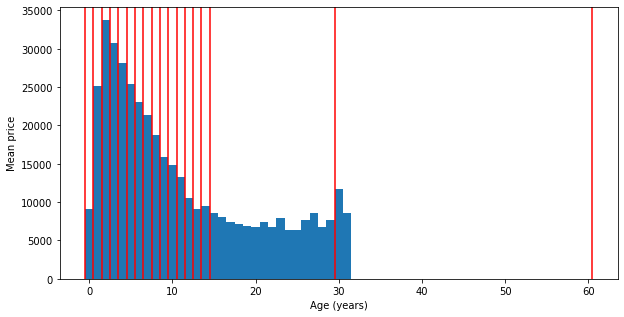

In [126]:
dfAgeCat = dfAge.copy()
thresholds = [30,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]
groups = ['over 30','15-29','14','13','12','11','10','9','8','7','6','5','4','3','2','1']

x = (dfAgeCat.groupby(['age'],as_index = False).mean())['age'].tolist()
y = (dfAgeCat.groupby(['age'],as_index = False).mean())['price'].tolist()
fig = plt.figure(figsize=[10,5])
plt.ylabel('Mean price')
plt.xlabel('Age (years)')
plt.bar(x, y, width=1)
for t in thresholds:
    plt.axvline(t-0.5, color = 'red')

plt.axvline(-0.5, color = 'red')
plt.axvline(30.5, color = 'red')

Die Fahrzeuge werden nun nach ihrem Alter in Gruppen eingeteilt und der neue Dataframe wird dann auf seine Performance getestet.

In [127]:
arr = np.array(dfAgeCat['age'].tolist())
for t in thresholds:
    prevArr = arr
    arr = np.where(prevArr >= t, -t, prevArr)
    
prevArr = arr
dfAgeCat['age_group'] = np.where(prevArr >= 0, 'new', prevArr).tolist()

for i in range(len(thresholds)):
     toReplace = str(float(-thresholds[i]))
     dfAgeCat['age_group'].replace(toReplace, groups[i], inplace =  True)

dfAgeCat.drop('age', axis=1, inplace=True)    
print(dfAgeCat['age_group'].unique())
dfAgeCat

['8' '12' '2' '5' '9' '10' '6' '3' '11' 'over 30' '4' '15-29' '7' '14'
 '13' '1' 'new']


,price,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,car_model,age_group
27,33590,good,8 cylinders,gas,57923.0,other,4wd,pickup,white,al,2021-05,8
28,22590,good,8 cylinders,gas,71229.0,other,4wd,pickup,blue,al,2021-05,12
29,39590,good,8 cylinders,gas,19160.0,other,4wd,pickup,red,al,2021-05,2
30,30990,good,8 cylinders,gas,41124.0,other,4wd,pickup,red,al,2021-05,5
31,15000,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,al,2021-05,9
...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,good,6 cylinders,gas,32226.0,other,fwd,sedan,unknown,wy,2021-04,3
426876,30590,good,6 cylinders,gas,12029.0,other,fwd,sedan,red,wy,2021-04,2
426877,34990,good,6 cylinders,diesel,4174.0,other,4wd,hatchback,white,wy,2021-04,2
426878,28990,good,6 cylinders,gas,30112.0,other,fwd,sedan,silver,wy,2021-04,4


In [128]:
age_cat_metrics = updateModel(dfAgeCat)
print_metrics(age_cat_metrics)

test performance: {'r2': 66.39, 'mae': 5302.43, 'mse': 53664352.84, 'mape': 171.15}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 66.27, 'mae': 5311.83, 'mse': 54097309.47, 'mape': 175.12}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 3.21 %


Mit der nachfolgenden Schleife wird der Einfluss der restlichen Spalten auf den Preis grafisch dargestellt.

condition


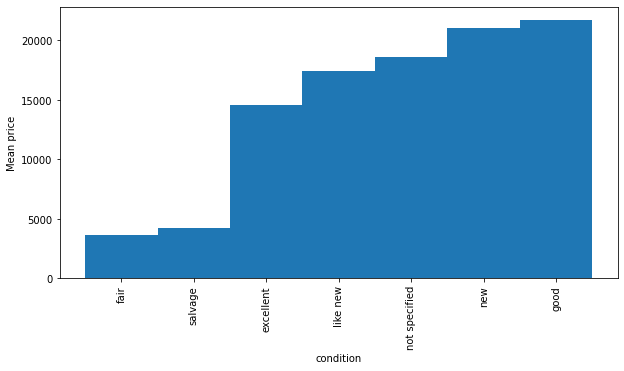

cylinders


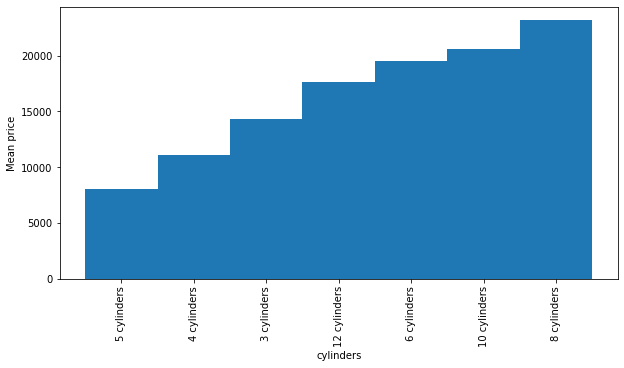

fuel


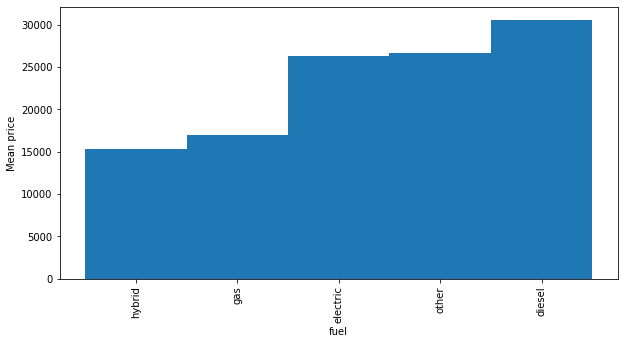

transmission


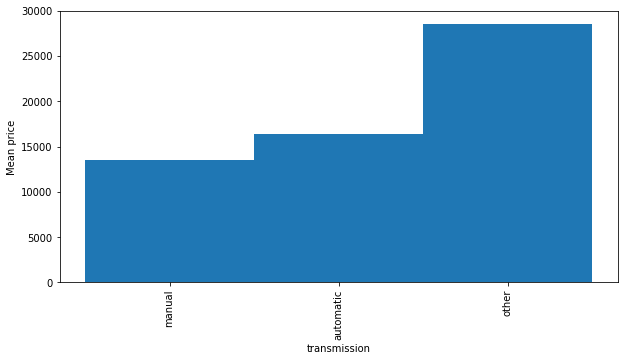

drive


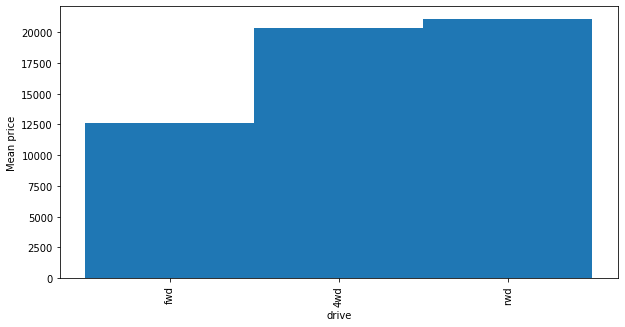

type


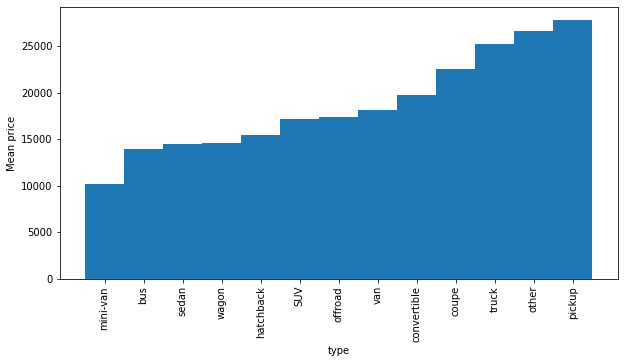

paint_color


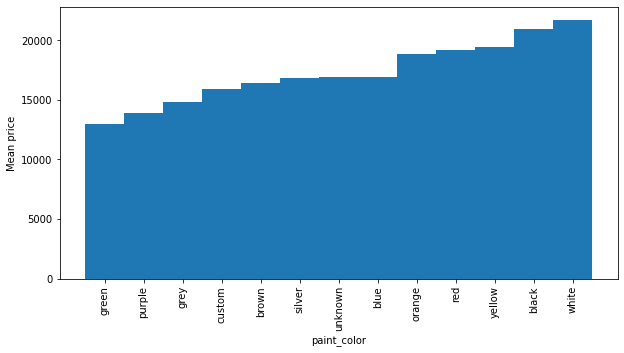

state


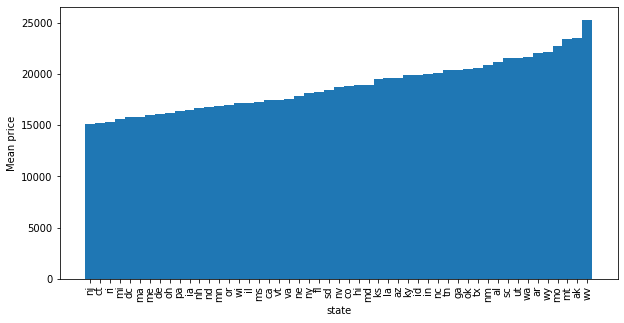

In [129]:
dfPlots = dfAge.copy()
for feat in dfAgeCat.drop(['price','odometer','car_model','age_group'], axis = 1).columns:
    print(feat)
    x = (dfPlots.groupby(feat, as_index = False).mean()).sort_values(by = ['price'])[feat]
    y = (dfPlots.groupby(feat, as_index = False).mean()).sort_values(by = ['price'])['price']
    fig = plt.figure(figsize=[10,5])
    plt.xlabel(feat)
    plt.ylabel('Mean price')
    plt.xticks(rotation = 90)
    plt.bar(x, y, width=1)
    plt.show()

Die Gruppe good und not specified werden in einer Gruppe zusammengefasst und den anderen Integerwerte als neuen Namen für das Model zugeordnet.
Mit dem daraus resultierenden Dataframe wird wieder der Einfluss auf das Model getestet.

In [130]:
dfCondition = df.copy()

dfCondition['condition'].replace('new', 6, inplace =  True)
dfCondition['condition'].replace('like new', 5, inplace =  True)
dfCondition['condition'].replace('excellent', 4, inplace =  True)
dfCondition['condition'].replace('good', 3, inplace =  True)
dfCondition['condition'].replace('fair', 2, inplace =  True)
dfCondition['condition'].replace('salvage', 1, inplace =  True)
dfCondition['condition'].replace('not specified', 3, inplace =  True)

dfCondition['condition'].unique()

array([3, 4, 2, 5, 6, 1], dtype=int64)

In [131]:
condition_metrics = updateModel(dfCondition)
print_metrics(condition_metrics)

test performance: {'r2': 64.63, 'mae': 5484.95, 'mse': 56487690.99, 'mape': 175.14}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 64.38, 'mae': 5502.02, 'mse': 57121710.63, 'mape': 180.22}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: -0.12 %


Als nächstes soll der Einfluss der Zylinder auf die Preise getestet werden.

In [132]:
dfNoCyl = df.drop('cylinders', axis = 1)
dfNoCyl

,price,year,condition,fuel,odometer,transmission,drive,type,paint_color,state,car_model
27,33590,2014.0,good,gas,57923.0,other,4wd,pickup,white,al,2021-05
28,22590,2010.0,good,gas,71229.0,other,4wd,pickup,blue,al,2021-05
29,39590,2020.0,good,gas,19160.0,other,4wd,pickup,red,al,2021-05
30,30990,2017.0,good,gas,41124.0,other,4wd,pickup,red,al,2021-05
31,15000,2013.0,excellent,gas,128000.0,automatic,rwd,truck,black,al,2021-05
...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,good,gas,32226.0,other,fwd,sedan,unknown,wy,2021-04
426876,30590,2020.0,good,gas,12029.0,other,fwd,sedan,red,wy,2021-04
426877,34990,2020.0,good,diesel,4174.0,other,4wd,hatchback,white,wy,2021-04
426878,28990,2018.0,good,gas,30112.0,other,fwd,sedan,silver,wy,2021-04


In [133]:
no_cyl_metrics = updateModel(dfNoCyl)
print_metrics(no_cyl_metrics)

test performance: {'r2': 62.76, 'mae': 5651.89, 'mse': 59471005.67, 'mape': 179.36}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 62.49, 'mae': 5663.93, 'mse': 60159812.98, 'mape': 184.75}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: -3.16 %


Als nächstes soll der Einfluss des Fahrzeugtyps auf die Preise getestet werden.

In [134]:
dfNoType = df.drop('type', axis = 1)
dfNoType

,price,year,condition,cylinders,fuel,odometer,transmission,drive,paint_color,state,car_model
27,33590,2014.0,good,8 cylinders,gas,57923.0,other,4wd,white,al,2021-05
28,22590,2010.0,good,8 cylinders,gas,71229.0,other,4wd,blue,al,2021-05
29,39590,2020.0,good,8 cylinders,gas,19160.0,other,4wd,red,al,2021-05
30,30990,2017.0,good,8 cylinders,gas,41124.0,other,4wd,red,al,2021-05
31,15000,2013.0,excellent,6 cylinders,gas,128000.0,automatic,rwd,black,al,2021-05
...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,good,6 cylinders,gas,32226.0,other,fwd,unknown,wy,2021-04
426876,30590,2020.0,good,6 cylinders,gas,12029.0,other,fwd,red,wy,2021-04
426877,34990,2020.0,good,6 cylinders,diesel,4174.0,other,4wd,white,wy,2021-04
426878,28990,2018.0,good,6 cylinders,gas,30112.0,other,fwd,silver,wy,2021-04


In [135]:
no_type_metrics = updateModel(dfNoType)
print_metrics(no_type_metrics)

test performance: {'r2': 62.4, 'mae': 5724.28, 'mse': 60044599.28, 'mape': 177.64}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 62.23, 'mae': 5738.8, 'mse': 60569261.79, 'mape': 182.95}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: -4.49 %


Aus den Tests ergab sich, dass nur das zusammenfassen nach Alter einen positiven Einfluss auf das Model hatte.

In [136]:
df = dfAgeCat

Mit dem upgedateten Dataframe wird nun erneut die lineare Regression getestet.

In [137]:
reg = LinearRegression()
initLR = updateModel(df)
print_metrics(initLR)

test performance: {'r2': 66.39, 'mae': 5302.43, 'mse': 53664352.84, 'mape': 171.15}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 66.27, 'mae': 5311.83, 'mse': 54097309.47, 'mape': 175.12}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 3.21 %


Als nächstes testen wir als Model den RandomForestRegressor. Den Random_state setzen wir fest, damit dieser auch bei mehrfacher durchführung reproduzierbar ist.

In [138]:
reg = RandomForestRegressor(n_estimators = 20, random_state = 42)
initRF = updateModel(df)
print_metrics(initRF)

test performance: {'r2': 87.25, 'mae': 2376.12, 'mse': 20364381.82, 'mape': 73.5}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 97.82, 'mae': 939.06, 'mse': 3494798.32, 'mape': 28.99}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 56.63 %


Um ein repräsentativeres Ergebnis zu erhalten und das Model zuverlässiger zu machen, unterteilen wir die Daten in  fünf (Standartwert) unterschiedliche kleinere Datenpakete, auf denen wir das Model testen.

In [139]:
kcv = get_kCVscores(df)
kcv
print('Cross validated MAE mean:', kcv.mean())
print('Cross validated MAE standard deviation:', kcv.std())

Cross validated MAE mean: 3563.834753080374
Cross validated MAE standard deviation: 252.3821158044615


Zum Vergleich wird nun der RandomForestRegressor mit mehr Verzweigungen getestet und angezeigt werden. 

In [140]:
reg = RandomForestRegressor(n_estimators = 100, random_state = 42)
init100RF = updateModel(df)
print_metrics(init100RF)

test performance: {'r2': 87.75, 'mae': 2324.52, 'mse': 19558465.65, 'mape': 73.34}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 98.12, 'mae': 894.14, 'mse': 3010913.6, 'mape': 28.65}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 57.57 %


Nun soll auch der MLPRegressor als Neuronales Netz getestet werden und es soll das Ergebnis angezeigt werden.

In [141]:
reg = MLPRegressor()
initNN = updateModel(df)
print_metrics(initNN)

C:\Users\oache\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


test performance: {'r2': 74.79, 'mae': 4370.27, 'mse': 40253517.5, 'mape': 133.85}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 75.21, 'mae': 4337.54, 'mse': 39757114.4, 'mape': 136.33}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 20.23 %


Mithilfe von K_means soll nun der Datensatz einmal in die wichtigsten zwei und einmal die drei wichtigsten cluster eingeteilt werden.

In [142]:
df_clustering_k2 = k_means_clustering(df, 2)
df_clustering_k2

,price,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,car_model,age_group,cluster
27,33590,good,8 cylinders,gas,57923.0,other,4wd,pickup,white,al,2021-05,8,0
28,22590,good,8 cylinders,gas,71229.0,other,4wd,pickup,blue,al,2021-05,12,0
29,39590,good,8 cylinders,gas,19160.0,other,4wd,pickup,red,al,2021-05,2,0
30,30990,good,8 cylinders,gas,41124.0,other,4wd,pickup,red,al,2021-05,5,0
31,15000,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,al,2021-05,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,good,6 cylinders,gas,32226.0,other,fwd,sedan,unknown,wy,2021-04,3,0
426876,30590,good,6 cylinders,gas,12029.0,other,fwd,sedan,red,wy,2021-04,2,0
426877,34990,good,6 cylinders,diesel,4174.0,other,4wd,hatchback,white,wy,2021-04,2,0
426878,28990,good,6 cylinders,gas,30112.0,other,fwd,sedan,silver,wy,2021-04,4,0


In [143]:
df_clustering_k3 = k_means_clustering(df, 3)
df_clustering_k3

,price,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,car_model,age_group,cluster
27,33590,good,8 cylinders,gas,57923.0,other,4wd,pickup,white,al,2021-05,8,1
28,22590,good,8 cylinders,gas,71229.0,other,4wd,pickup,blue,al,2021-05,12,0
29,39590,good,8 cylinders,gas,19160.0,other,4wd,pickup,red,al,2021-05,2,1
30,30990,good,8 cylinders,gas,41124.0,other,4wd,pickup,red,al,2021-05,5,1
31,15000,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,al,2021-05,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,good,6 cylinders,gas,32226.0,other,fwd,sedan,unknown,wy,2021-04,3,1
426876,30590,good,6 cylinders,gas,12029.0,other,fwd,sedan,red,wy,2021-04,2,1
426877,34990,good,6 cylinders,diesel,4174.0,other,4wd,hatchback,white,wy,2021-04,2,1
426878,28990,good,6 cylinders,gas,30112.0,other,fwd,sedan,silver,wy,2021-04,4,1


In [144]:
#pd.get_dummies(df_clustering_k2, drop_first = True).groupby(['cluster']).median()

In [145]:
#pd.get_dummies(df_clustering_k3, drop_first = True).groupby(['cluster']).median()

In [146]:
df_to_use = pd.get_dummies(df_clustering_k2, drop_first = True)
k = 2
print('For k = ', k)

list_of_results = []
for i in range(k):
    cluster_df = (df_to_use[df_to_use['cluster']==i]).copy()
    res = updateModel(cluster_df)
    print_metrics(res)
    list_of_results.append(res)

clust_k2_LR_results = list_of_results

For k =  2


C:\Users\oache\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


test performance: {'r2': 62.81, 'mae': 5373.33, 'mse': 55937882.46, 'mape': 160.1}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 63.14, 'mae': 5315.34, 'mse': 54811926.2, 'mape': 171.69}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 1.92 %


C:\Users\oache\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


test performance: {'r2': 74.69, 'mae': 3121.79, 'mse': 21527774.73, 'mape': 93.94}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 75.69, 'mae': 3049.12, 'mse': 20303572.3, 'mape': 92.49}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 43.02 %


In [147]:
df_to_use = pd.get_dummies(df_clustering_k3, drop_first = True)
k = 3
print('For k = ', k)

list_of_results = []
for i in range(k):
    cluster_df = (df_to_use[df_to_use['cluster']==i]).copy()
    res = updateModel(cluster_df)
    print_metrics(res)
    list_of_results.append(res)

clust_k3_LR_results = list_of_results

For k =  3


C:\Users\oache\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


test performance: {'r2': 68.02, 'mae': 3976.14, 'mse': 32938145.25, 'mape': 138.03}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 68.85, 'mae': 3952.25, 'mse': 32819150.71, 'mape': 136.04}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 27.42 %


C:\Users\oache\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


test performance: {'r2': 55.28, 'mae': 5746.08, 'mse': 62826556.87, 'mape': 177.42}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 55.97, 'mae': 5667.73, 'mse': 61453184.77, 'mape': 181.35}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: -4.88 %
test performance: {'r2': 78.54, 'mae': 2640.57, 'mse': 14738376.0, 'mape': 73.53}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 78.76, 'mae': 2614.76, 'mse': 14841346.12, 'mape': 71.72}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 51.8 %


C:\Users\oache\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Das Clustern mit zwei Klassen liefert die besseren Ergebnisse. 

Zum Vergleich wird auch der RandomForestRegressor mit zwei Clustern getestet.

In [148]:
reg = RandomForestRegressor(n_estimators = 20, random_state = 42)

In [149]:
df_to_use = pd.get_dummies(df_clustering_k2, drop_first = True)
k = 2
print('For k = ', k)

list_of_results = []
for i in range(k):
    cluster_df = (df_to_use[df_to_use['cluster']==i]).copy()
    res = updateModel(cluster_df)
    print_metrics(res)
    list_of_results.append(res)

clust_k2_RF_results = list_of_results

For k =  2
test performance: {'r2': 81.57, 'mae': 2675.9, 'mse': 27724589.15, 'mape': 82.06}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 96.91, 'mae': 1042.73, 'mse': 4599382.35, 'mape': 34.69}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 51.16 %
test performance: {'r2': 84.96, 'mae': 2059.09, 'mse': 12792108.4, 'mape': 55.01}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 97.52, 'mae': 798.84, 'mse': 2068255.48, 'mape': 22.26}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 62.42 %


In [150]:
print_metrics(initRF)

test performance: {'r2': 87.25, 'mae': 2376.12, 'mse': 20364381.82, 'mape': 73.5}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 97.82, 'mae': 939.06, 'mse': 3494798.32, 'mape': 28.99}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 56.63 %


Mithilfe der Clusterung konnte das Ergebnis des RFR weiter optimiert werden und liefert so mit die bester Vorhersage. Wir bilden das Finale CSV und Model.

In [151]:
dfFinal = df_clustering_k2.copy()
dfFinal

,price,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,car_model,age_group,cluster
27,33590,good,8 cylinders,gas,57923.0,other,4wd,pickup,white,al,2021-05,8,0
28,22590,good,8 cylinders,gas,71229.0,other,4wd,pickup,blue,al,2021-05,12,0
29,39590,good,8 cylinders,gas,19160.0,other,4wd,pickup,red,al,2021-05,2,0
30,30990,good,8 cylinders,gas,41124.0,other,4wd,pickup,red,al,2021-05,5,0
31,15000,excellent,6 cylinders,gas,128000.0,automatic,rwd,truck,black,al,2021-05,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,good,6 cylinders,gas,32226.0,other,fwd,sedan,unknown,wy,2021-04,3,0
426876,30590,good,6 cylinders,gas,12029.0,other,fwd,sedan,red,wy,2021-04,2,0
426877,34990,good,6 cylinders,diesel,4174.0,other,4wd,hatchback,white,wy,2021-04,2,0
426878,28990,good,6 cylinders,gas,30112.0,other,fwd,sedan,silver,wy,2021-04,4,0


In [152]:
finalPerformance = clust_k2_RF_results
print('Cluster 1:')
print_metrics(finalPerformance[0])
print()
print('Cluster 2:')
print_metrics(finalPerformance[1])

Cluster 1:
test performance: {'r2': 81.57, 'mae': 2675.9, 'mse': 27724589.15, 'mape': 82.06}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 96.91, 'mae': 1042.73, 'mse': 4599382.35, 'mape': 34.69}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 51.16 %

Cluster 2:
test performance: {'r2': 84.96, 'mae': 2059.09, 'mse': 12792108.4, 'mape': 55.01}
initial test performance: {'r2': 64.72, 'mae': 5478.5, 'mse': 56333849.5, 'mape': 175.52}

train performance: {'r2': 97.52, 'mae': 798.84, 'mse': 2068255.48, 'mape': 22.26}
initial train performance: {'r2': 64.48, 'mae': 5492.52, 'mse': 56959948.0, 'mape': 180.65}

change in test MAE: 62.42 %


In [153]:
finalModel = reg
reg

RandomForestRegressor(n_estimators=20, random_state=42)

In [154]:
#finalClusters = df_clustering_k2.copy()
#pd.get_dummies(finalClusters, drop_first = True).groupby(['cluster']).median()

In [155]:
dfFinal.to_csv('final')